# Basic Modeling

This notebook models interest_level using base numeric features with minimal pre-processing

### Required imports

In [44]:
# Pandas and Numpy for data structures and util fucntions
import re
import itertools
import numpy as np
import pandas as pd
from numpy.random import rand
from datetime import datetime
pd.options.display.max_colwidth = 600

# Statsmodels functions
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose

# Scikit Imports
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve


# Matplot Imports
import matplotlib.pyplot as plt
#plt.xkcd()

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load Data and Describe

In [39]:
def pp_base_features(input_df, is_train=True):
    input_df.created = pd.to_datetime(input_df.created)
    if is_train:
        input_df['interest_level'] = input_df['interest_level'].apply(
                                                            lambda x: 0 if x=="low" 
                                                                        else 1 if x =="medium" else 2)
    input_df['image_cnt'] = input_df['photos'].apply(lambda x: len(x))
    input_df['listing_cnt'] = 1
    return input_df

In [3]:
train_df = pd.read_json(r'data\train.json')
train_df = pp_base_features(train_df)

In [4]:
train_df.dtypes

bathrooms                 float64
bedrooms                    int64
building_id                object
created            datetime64[ns]
description                object
display_address            object
features                   object
interest_level              int64
latitude                  float64
listing_id                  int64
longitude                 float64
manager_id                 object
photos                     object
price                       int64
street_address             object
image_cnt                   int64
listing_cnt                 int64
dtype: object

In [5]:
train_df.shape

(49352, 17)

### Pick only numeric attributes for modeling

In [6]:
subset_df = train_df[['bathrooms',
                      'bedrooms',
                      #'building_id',
                      'latitude',
                      'longitude',
                      #'listing_id',
                      'price',
                      'image_cnt',
                      'interest_level']]
subset_df.shape

(49352, 7)

In [7]:
# split train, test for calibration
X_train, X_test, y_train, y_test = train_test_split(subset_df.ix[:,:-1], subset_df.ix[:,-1], random_state=42)

In [8]:
print X_train.shape
print X_test.shape

(37014, 6)
(12338, 6)


## Simple Model 
* Out of the box SVM
* Calculate Mean Score and Log Loss

In [61]:
ovr_svc_classifier = svm.SVC(probability=True,verbose=True)

In [62]:
ovr_svc_classifier.fit(np.array(X_train),np.array(y_train))

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [63]:
test_proba = ovr_svc_classifier.predict_proba(np.array(X_test))
test_label = ovr_svc_classifier.predict(np.array(X_test))

In [64]:
print "mean score:",ovr_svc_classifier.score(np.array(X_test),np.array(y_test))
print "log_loss:",log_loss(np.array(y_test),np.array(test_proba))

mean score: 0.69314313503
log_loss: 0.769252955596


Confusion matrix, without normalization
[[8305  159   27]
 [2704  170   30]
 [ 766  100   77]]


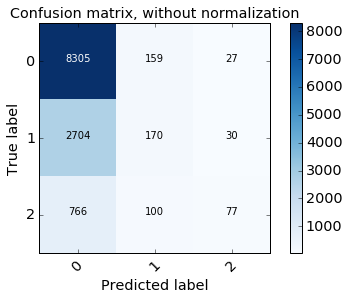

In [65]:
cnf_matrix = confusion_matrix(y_test, test_label)
plot_confusion_matrix(cnf_matrix, classes=[0,1,2],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

### Out of the box we are able to achieve 0.76 Log Loss on train (split to train-test). 
* This would land us around 1500 mark on the LB
* Class distribution is skewed (saw similar skew during data exploration)
---

### Scale Data and check Variation in Log Loss

In [66]:
scaler = preprocessing.StandardScaler().fit(np.array(X_train))

In [67]:
scaled_X_train = scaler.transform(np.array(X_train))
scaled_X_test = scaler.transform(np.array(X_test))

In [68]:
ovr_svc_classifier_scaled = svm.SVC(probability=True,verbose=True)

In [69]:
ovr_svc_classifier_scaled.fit(np.array(scaled_X_train),np.array(y_train))

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [70]:
test_proba_scaled = ovr_svc_classifier_scaled.predict_proba(np.array(scaled_X_test))
test_label_scaled = ovr_svc_classifier_scaled.predict(np.array(scaled_X_test))

In [71]:
print "mean score:",ovr_svc_classifier_scaled.score(np.array(scaled_X_test),np.array(y_test))
print "log_loss:",log_loss(np.array(y_test),np.array(test_proba_scaled))

mean score: 0.688199059815
log_loss: 0.789816642285


Confusion matrix, without normalization
[[8491    0    0]
 [2904    0    0]
 [ 943    0    0]]


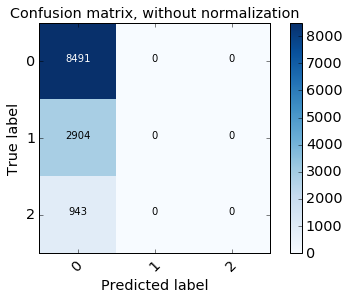

In [72]:
cnf_matrix = confusion_matrix(y_test, test_label_scaled)
plot_confusion_matrix(cnf_matrix, classes=[0,1,2],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

### Scaling the data using standard scaler seems to have worsened the results. Why is this the case?
---

## Test Data
* Load Test JSON
* Apply Classification Model
* Dump CSV and upload results

In [73]:
test_df = pd.read_json(r'data\test.json')
test_df.shape

(74659, 14)

In [74]:
test_df = pp_base_features(test_df,is_train=False)
test_df.shape

(74659, 16)

In [75]:
#'listing_id'
feature_list = ['bathrooms',
                      'bedrooms',
                      'latitude',
                      'longitude',
                      'price',
                      'image_cnt']

In [76]:
test_proba_scaled = ovr_svc_classifier.predict_proba(np.array(test_df[feature_list]))

In [86]:
output_df = pd.DataFrame(data={'listing_id':test_df.listing_id,
                               'high':test_proba_scaled[:,2],
                               'medium':test_proba_scaled[:,1],
                               'low':test_proba_scaled[:,0]})
output_df[['listing_id','high','medium','low']].to_csv(r'data\model_001_svm.csv',index=False)

### Persist Model for Future analysis

In [85]:
import cPickle

# save the oob classifier
with open(r'data\model_001_svm.pkl', 'wb') as fid:
    cPickle.dump(ovr_svc_classifier, fid)   

# saved scaled classifier
with open(r'data\model_001_svm_scaled.pkl', 'wb') as fid:
    cPickle.dump(ovr_svc_classifier_scaled, fid)   

### Next Steps before moving to other Classifiers
* Try Model Tuning using Grid Search over C, Gamma, Kernels, Loss Function
* Try OVO and OVR strategies
* Write utility funtions for quick turn around in a seprate py file

Collect results and discuss why they are improving or worsening and note the same in the next notebook